## Training

In [2]:
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
from keras.initializers import glorot_uniform

import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("models/")
sys.path.append("scripts/")

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1, 2, 3"

In [4]:
from my_classes import DataGenerator, AugmentedDataGenerator

In [5]:
# Load the data
h5f = h5py.File('data/data_nearest_neighbor.h5', 'r')
train_x, train_y = h5f['train_x'][:], h5f['train_y'][:]
valid_x, valid_y = h5f['valid_x'][:], h5f['valid_y'][:]
test_x, test_y = h5f['test_x'][:], h5f['test_y'][:]
h5f.close()

print(train_x.shape, valid_x.shape, test_x.shape)

(3012, 24, 24, 24, 16) (377, 24, 24, 24, 16) (376, 24, 24, 24, 16)


In [6]:
from models import Squeeze_model

In [7]:
# from IPython.display import SVG
# from keras.utils.vis_utils import plot_model, model_to_dot
# model_input = Input(shape=(24, 24, 24, 16))
# squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
# #plot_model(squeeze_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(squeeze_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
# # plot_model(get_model4((24, 24, 24, 16)))

In [8]:
# Training parameters
nb_gpus = 4
nb_batch = nb_gpus*3
nb_epochs =200
l_rate = 1e-4

In [9]:
# checkpoint
outputFolder = './weights'
# if not os.path.exists(outputFolder):
#     os.makedirs(outputFolder)

filepath=outputFolder+"/weights-rotated_90.h5"

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks_list = [ModelCheckpoint(filepath, 
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)]

In [10]:
model_input = Input(shape=(24, 24, 24, 16))
squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
model = multi_gpu_model(squeeze_model, gpus=nb_gpus)

model.compile(optimizer=optimizers.adam(lr=l_rate),# beta_1=0.99, beta_2=0.999),
              loss='mean_absolute_error')

In [11]:
aug_data_gen = AugmentedDataGenerator(x=train_x, y=train_y, batch_size=nb_batch)
aug_val_gen = AugmentedDataGenerator(x=valid_x, y=valid_y, batch_size=nb_batch)

In [12]:
for x, y in aug_data_gen:
    print(x.shape, y.shape)
    break

(288, 24, 24, 24, 16) (288,)


In [13]:
history = model.fit_generator(generator=aug_data_gen,validation_data=aug_val_gen,
                              use_multiprocessing=False, 
                              epochs=nb_epochs, 
                              max_queue_size=5, 
                              workers=56, 
                              verbose=1, callbacks = callbacks_list)

Epoch 1/200
251/251 [==============================] - 144s 573ms/step - loss: 2.1194 - val_loss: 1.6938

Epoch 00001: val_loss improved from inf to 1.69385, saving model to ./weights/weights-rotated_90.h5
Epoch 2/200
251/251 [==============================] - 139s 555ms/step - loss: 1.5529 - val_loss: 1.3971

Epoch 00002: val_loss improved from 1.69385 to 1.39708, saving model to ./weights/weights-rotated_90.h5
Epoch 3/200
251/251 [==============================] - 142s 564ms/step - loss: 1.5366 - val_loss: 1.3188

Epoch 00003: val_loss improved from 1.39708 to 1.31881, saving model to ./weights/weights-rotated_90.h5
Epoch 4/200
251/251 [==============================] - 145s 576ms/step - loss: 1.4441 - val_loss: 1.6974

Epoch 00004: val_loss did not improve from 1.31881
Epoch 5/200
251/251 [==============================] - 144s 575ms/step - loss: 1.5115 - val_loss: 1.4861

Epoch 00005: val_loss did not improve from 1.31881
Epoch 6/200
251/251 [==============================] - 148s 

251/251 [==============================] - 174s 693ms/step - loss: 0.6674 - val_loss: 1.4013

Epoch 00051: val_loss did not improve from 1.19788
Epoch 52/200
251/251 [==============================] - 173s 687ms/step - loss: 0.6393 - val_loss: 1.3950

Epoch 00052: val_loss did not improve from 1.19788
Epoch 53/200
251/251 [==============================] - 172s 686ms/step - loss: 0.6094 - val_loss: 1.4207

Epoch 00053: val_loss did not improve from 1.19788
Epoch 54/200
251/251 [==============================] - 172s 686ms/step - loss: 0.6109 - val_loss: 1.3847

Epoch 00054: val_loss did not improve from 1.19788
Epoch 55/200
251/251 [==============================] - 175s 696ms/step - loss: 0.6124 - val_loss: 1.4091

Epoch 00055: val_loss did not improve from 1.19788
Epoch 56/200
251/251 [==============================] - 173s 689ms/step - loss: 0.5679 - val_loss: 1.3509

Epoch 00056: val_loss did not improve from 1.19788
Epoch 57/200
251/251 [==============================] - 175s 697m

251/251 [==============================] - 183s 728ms/step - loss: 0.2552 - val_loss: 1.4390

Epoch 00103: val_loss did not improve from 1.19788
Epoch 104/200
251/251 [==============================] - 182s 724ms/step - loss: 0.2452 - val_loss: 1.4947

Epoch 00104: val_loss did not improve from 1.19788
Epoch 105/200
251/251 [==============================] - 177s 707ms/step - loss: 0.2566 - val_loss: 1.4743

Epoch 00105: val_loss did not improve from 1.19788
Epoch 106/200
251/251 [==============================] - 181s 721ms/step - loss: 0.2463 - val_loss: 1.4538

Epoch 00106: val_loss did not improve from 1.19788
Epoch 107/200
251/251 [==============================] - 181s 721ms/step - loss: 0.2476 - val_loss: 1.4581

Epoch 00107: val_loss did not improve from 1.19788
Epoch 108/200
251/251 [==============================] - 180s 719ms/step - loss: 0.2396 - val_loss: 1.4434

Epoch 00108: val_loss did not improve from 1.19788
Epoch 109/200
251/251 [==============================] - 178


Epoch 00154: val_loss did not improve from 1.19788
Epoch 155/200
251/251 [==============================] - 185s 736ms/step - loss: 0.1893 - val_loss: 1.4120

Epoch 00155: val_loss did not improve from 1.19788
Epoch 156/200
251/251 [==============================] - 190s 757ms/step - loss: 0.1931 - val_loss: 1.4077

Epoch 00156: val_loss did not improve from 1.19788
Epoch 157/200
251/251 [==============================] - 185s 735ms/step - loss: 0.2042 - val_loss: 1.3980

Epoch 00157: val_loss did not improve from 1.19788
Epoch 158/200
251/251 [==============================] - 188s 751ms/step - loss: 0.1800 - val_loss: 1.4095

Epoch 00158: val_loss did not improve from 1.19788
Epoch 159/200
251/251 [==============================] - 187s 744ms/step - loss: 0.1918 - val_loss: 1.5038

Epoch 00159: val_loss did not improve from 1.19788
Epoch 160/200
251/251 [==============================] - 192s 766ms/step - loss: 0.1929 - val_loss: 1.4708

Epoch 00160: val_loss did not improve from 1.

In [14]:
# Save the history
import pickle

with open(os.path.join(outputFolder, "history_rotated_90.pickle"), 'wb') as f:
    pickle.dump(history.history, f)

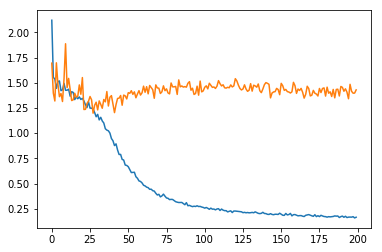

In [15]:
# First 100 epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [33]:
# Save the weights
# model.save_weights('weights/weights_rotated_90.h5')

In [16]:
from sklearn.metrics import r2_score

In [17]:
model.load_weights("weights/weights-rotated_90.h5")

In [18]:
sample_size = 200
rotation_count = 24

train_aug_data_gen = AugmentedDataGenerator(x=train_x,
                                            y=train_y,
                                            batch_size=sample_size)
# Two chunks to avoid memory issues
test_aug_data_gen= AugmentedDataGenerator(x=test_x[:sample_size],
                                            y=test_y[:sample_size],
                                            batch_size=sample_size)

# Train r2

for x, y in train_aug_data_gen:
    # Without average
    train_r2 = r2_score(y_true=y, y_pred=model.predict(x))
    print("Train r2 (without average): ", train_r2)
    
    # With average
    y_pred = model.predict(x)[:, 0]
    
    sample_y = np.zeros(sample_size)
    sample_ypred = np.zeros(sample_size)
    for i in range(sample_size):
        start = i*rotation_count
        end = i*rotation_count + rotation_count
        mean_ypred = np.mean(y_pred[start:end])
        mean_y = np.mean(y[start:end])
        sample_ypred[i] = mean_ypred
        sample_y[i] = mean_y
    
    train_r2 = r2_score(y_true=sample_y, y_pred=sample_ypred)
    print("Train r2 (with average): ", train_r2)
    break
    
#sample_size = test_x.shape[0]
    
# Test r2

for x, y in test_aug_data_gen:
    # Without average
    test_r2 = r2_score(y_true=y, y_pred=model.predict(x))
    print("Test r2 (without average): ", test_r2)
    
    # With average
    y_pred = model.predict(x)[:, 0]
    
    sample_y = np.zeros(sample_size)
    sample_ypred = np.zeros(sample_size)
    for i in range(sample_size):
        start = i*rotation_count
        end = i*rotation_count + rotation_count
        mean_ypred = np.mean(y_pred[start:end])
        mean_y = np.mean(y[start:end])
        sample_ypred[i] = mean_ypred
        sample_y[i] = mean_y
    
    test_r2 = r2_score(y_true=sample_y, y_pred=sample_ypred)
    print("Test r2 (with average): ", test_r2)
    break

Train r2 (without average):  0.42386172896
Train r2 (with average):  0.450857804803
Test r2 (without average):  0.296750854835
Test r2 (with average):  0.318541544718
